In [1]:
inputDay1 = "21752342814933766938172121674976879111362417653261522357855816893656462449168377359285244818489723869987861247912289729579296691684761143544956991583942215236568961875851755854977946147178746464675227699149925227227137557479769948569788884399379821111382536722699575759474473273939756348992714667963596189765734743169489599125771443348193383566159843593541134749392569865481578359825844394454173219857919349341442148282229689541561169341622222354651397342928678496478671339383923769856425795211323673389723181967933933832711545885653952861879231537976292517866354812943192728263269524735698423336673735158993853556148833861327959262254756647827739145283577793481526768156921138428318939361859721778556264519643435871835744859243167227889562738712953651128317624673985213525897522378259178625416722152155728615936587369515254936828668564857283226439881266871945998796488472249182538883354186573925183152663862683995449671663285775397453876262722567452435914777363522817594741946638986571793655889466419895996924122915777224499481496837343194149123735355268151941712871245863553836953349887831949788869852929147849489265325843934669999391846286319268686789372513976522282587526866148166337215961493536262851512218794139272361292811529888161198799297966893366553115353639298256788819385272471187213579185523521341651117947676785341146235441411441813242514813227821843819424619974979886871646621918865274574538951761567855845681272364646138584716333599843835167373525248547542442942583122624534494442516259616973235858469131159773167334953658673271599748942956981954699444528689628848694446818825465485122869742839711471129862632128635779658365756362863627135983617613332849756371986376967117549251566281992964573929655589313871976556784849231916513831538254812347116253949818633527185174221565279775766742262687713114114344843534958833372634182176866315441583887177759222598853735114191874277711434653854816841589229914164681364497429324463193669337827467661773833517841763711156376147664749175267212562321567728575765844893232718971471289841171642868948852136818661741238178676857381583155547755219837116125995361896562498721571413742"

In [188]:
import numpy as np

lastDigit = " "
summands = []
for c in inputDay1:
    if lastDigit == c:
        summands.append(c)
    lastDigit = c
if inputDay1[-1] == inputDay1[0]:
    summands.append(inputDay1[-1])

sum = 0
for s in summands:
    sum = sum + int(s)
    
print(sum)

1119


In [3]:
step = len(inputDay1)/2
summands = []
for idx, val in enumerate(inputDay1):
    nextIndex = int((idx + step) % len(inputDay1))
    if val == inputDay1[nextIndex]:
        summands.append(val)
        
sum = 0
for s in summands:
    sum = sum + int(s)
    
print(sum)

1420


In [90]:
import numpy as np
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.models import Sequential
%matplotlib inline
import matplotlib.pyplot as plt


In [189]:
def generateSample(seq_len):
    x = np.random.choice(10, seq_len)
    summands = []
    lastVal = 0
    for c in x:
        if lastVal == c:
            summands.append(c)
        else:
            summands.append(0)
        lastVal = c
    y = 0
    for s in summands:
        y = y + int(s)
    return np.array(x).reshape(seq_len, 1), np.array(y).reshape(1)

In [190]:
x,y = generateSample(5)
x.shape
print(y)

[0]


In [191]:
def load_data(trainNumber, testNumber, seq_len):
    y_train = []
    x_train = []
    x_test = []
    y_test = []
    for i in range(trainNumber):
        x,y = generateSample(seq_len)
        x_train.append(x)
        y_train.append(y)
    for i in range(testNumber):
        x,y = generateSample(seq_len)
        x_test.append(x)
        y_test.append(y)
        
    return [
        np.array(x_train), 
        np.array(y_train), 
        np.array(x_test), 
        np.array(y_test)]


In [192]:
load_data(10,10,15)[0].shape

(10, 15, 1)

In [193]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        layers[1],
        input_shape=layers[0],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        layers[3]))
    model.add(Activation("linear"))

    model.compile(loss="mse", optimizer="rmsprop")
    return model

In [194]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [195]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

> Loading data... 
> Data Loaded. Compiling...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
dropout_61 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_69 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_62 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_28 (Activation)   (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________

950/950 [==============================] - 1s - loss: 125.0657 - val_loss: 121.6341
Epoch 72/100
950/950 [==============================] - 1s - loss: 121.7309 - val_loss: 123.5263
Epoch 73/100
950/950 [==============================] - 1s - loss: 139.6327 - val_loss: 125.7700
Epoch 74/100
950/950 [==============================] - 1s - loss: 126.1283 - val_loss: 121.6270
Epoch 75/100
950/950 [==============================] - 1s - loss: 122.0618 - val_loss: 126.1873
Epoch 76/100
950/950 [==============================] - 1s - loss: 125.1563 - val_loss: 128.6475
Epoch 77/100
950/950 [==============================] - 1s - loss: 123.7351 - val_loss: 122.7041
Epoch 78/100
950/950 [==============================] - 1s - loss: 122.5776 - val_loss: 121.5168
Epoch 79/100
950/950 [==============================] - 1s - loss: 123.6697 - val_loss: 123.7525
Epoch 80/100
950/950 [==============================] - 1s - loss: 126.7551 - val_loss: 120.8496
Epoch 81/100
950/950 [=====================

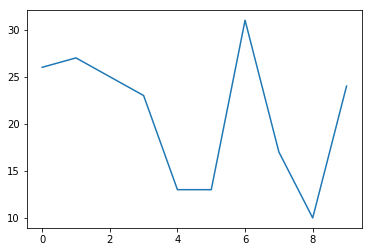

In [197]:
epochs  = 100
seq_len = 50

print('> Loading data... ')

X_train, Y_train, X_test, Y_test = load_data(1000, 10, seq_len)

print('> Data Loaded. Compiling...')

model = build_model([X_train.shape[1:],50, 100, 1])

model.summary()
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(X_train.shape))
print("Actual output: {}".format(Y_train.shape))

print (X_train.shape)

history = model.fit(
    X_train,
    Y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.05)
fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()  

predictions = predict_sequences_multiple(model, X_test, seq_len, 50)
#predicted = lstm.predict_sequence_full(model, X_test, seq_len)
#predicted = lstm.predict_point_by_point(model, X_test)        

plot_results_multiple(predictions, Y_test, 50)